In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split


# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [2]:
picture_size = 48
folder_path = "images/train"

In [3]:
def load_and_preprocess_images(folder_path, picture_size):
    images = []
    labels = []
    emotion_labels = sorted(os.listdir(folder_path))  # Lấy danh sách các thư mục (nhãn cảm xúc)

    for label in emotion_labels:
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Chuyển đổi ảnh sang màu xám
            image = cv2.resize(image, (picture_size, picture_size))  # Thay đổi kích thước ảnh
            image = image.astype('float32') / 255.0  # Chuẩn hóa ảnh
            images.append(image)
            labels.append(emotion_labels.index(label))  # Gán nhãn cảm xúc

    images = np.array(images)
    labels = np.array(labels)

    # Chuyển đổi hình ảnh thành định dạng phù hợp cho mô hình Keras
    images = np.expand_dims(images, -1)
    return images, labels

images, labels = load_and_preprocess_images(folder_path, picture_size)

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [6]:
def apply_gaussian_blur(images):
    blurred_images = []
    for image in images:
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        blurred_images.append(blurred_image)
    return np.array(blurred_images)

X_train_blurred = apply_gaussian_blur(X_train)

In [45]:
import tensorflow as tf
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(os.listdir(folder_path)), activation='softmax')
])

In [47]:
# Sử dụng optimizer khác (SGD với learning rate giảm dần)
optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [48]:
from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

In [49]:
# Compile mô hình
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Huấn luyện mô hình với các thay đổi
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_dev, y_dev),
                    epochs=50,  # Tăng số lượng epochs
                    callbacks=[lr_scheduler])

Epoch 1/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 73s 95ms/step - accuracy: 0.2054 - loss: 2.0816 - val_accuracy: 0.2578 - val_loss: 1.7758 - learning_rate: 0.0100
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 67s 92ms/step - accuracy: 0.2412 - loss: 1.8061 - val_accuracy: 0.2720 - val_loss: 1.9608 - learning_rate: 0.0100
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 67s 92ms/step - accuracy: 0.2527 - loss: 1.7814 - val_accuracy: 0.2505 - val_loss: 1.7991 - learning_rate: 0.0100
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.2579 - loss: 1.7749 - val_accuracy: 0.2769 - val_loss: 2.0264 - learning_rate: 0.0100
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 68s 94ms/step - accuracy: 0.2740 - loss: 1.7518 - val_accuracy: 0.3199 - val_loss: 1.6758 - learning_rate: 0.0100
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.2827 - loss: 1.7435 - val_accuracy: 0.3248 - val_loss: 1.6667 - learning_rate: 0.0100
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.2892 - l

In [51]:
# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5459 - loss: 1.1946
Test accuracy: 0.5355532169342041


In [52]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    
    # Biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    
    plt.show()

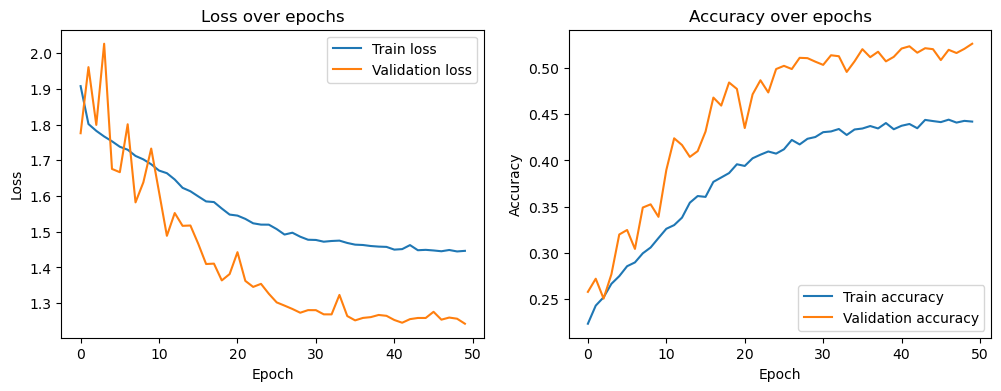

In [53]:
plot_history(history)

In [54]:
# Lưu mô hình vào file .h5
model.save('emotion2_model.h5')